## Fit execution time

This is connected to FLIP [#753](https://github.com/onflow/flow/pull/753)

`execution_effort/execution_time` should (on average) be a constant that only depends on the machine running the transactions, and not the transactions themselves.

We can set `execution_effort/execution_time=1` for the calibration machine.

the collected data has the first column as the transaction identifier (the transaction type) and the last column as the actual execution time in ms. The other columns are features.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr
from sklearn import linear_model
from sklearn import model_selection
import statsmodels.api as sm
import seaborn as sns


In [16]:
data = pd.read_csv("evm_data_2024_01.csv")
data.describe()


,GetAccountAvailableBalance,GetBlockAtHeight,RevokeEncodedAccountKey,AddEncodedAccountKey,CreateCompositeValue,CreateAccount,SetValue,GetStorageUsed,GenerateUUID,FunctionInvocation,...,Loop,CreateArrayValue,GetCode,EmitEvent,EVMGasUsage,GetValue,EncodeValue,EncodeEvent,estimated,ms
count,10940.000000,10940.0,10940.000000,10940.000000,10940.000000,10940.000000,1.094000e+04,10940.000000,10940.000000,10940.000000,...,10940.000000,10940.000000,10940.000000,1.094000e+04,1.094000e+04,1.094000e+04,1.094000e+04,10940.000000,1.094000e+04,10940.000000
mean,88.544698,0.0,236.507404,550.701645,2182.455302,62.958775,1.055015e+05,770.411517,832.636197,21496.166545,...,18886.875594,1931.437843,67.584278,3.321858e+05,1.735742e+06,8.203093e+05,5.158997e+04,2282.641316,9.289353e+04,229.880987
std,418.378354,0.0,1127.009269,1787.447572,5407.245275,207.065270,3.522588e+05,3552.900373,2378.102621,21041.389991,...,25225.464857,4497.748251,120.562455,6.959593e+05,8.036475e+06,1.923845e+06,2.332195e+05,5272.805577,9.783457e+04,894.943288
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,37.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2.600000e+01,0.000000
25%,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,6323.000000,...,3583.000000,0.000000,37.000000,0.000000e+00,0.000000e+00,2.210000e+02,0.000000e+00,0.000000,2.560925e+04,40.000000
50%,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,15629.500000,...,10204.000000,0.000000,37.000000,0.000000e+00,0.000000e+00,1.913000e+03,0.000000e+00,0.000000,6.185800e+04,116.000000
75%,0.000000,0.0,0.000000,0.000000,943.500000,0.000000,1.608000e+03,0.000000,0.000000,30314.500000,...,24776.250000,1264.250000,37.000000,2.330775e+05,0.000000e+00,3.054192e+05,1.271000e+03,1558.500000,1.269282e+05,265.000000
max,3343.000000,0.0,9696.000000,13329.000000,57642.000000,1888.000000,3.384151e+06,40314.000000,20672.000000,251337.000000,...,527755.000000,44308.000000,949.000000,5.652155e+06,6.545700e+07,1.576060e+07,2.094096e+06,53246.000000,1.246776e+06,42251.000000


outliers 759


(array([3250., 1745., 1139.,  912.,  837.,  711.,  579.,  474.,  323.,
         211.]),
 array([  3. ,  52.7, 102.4, 152.1, 201.8, 251.5, 301.2, 350.9, 400.6,
        450.3, 500. ]),
 <BarContainer object of 10 artists>)

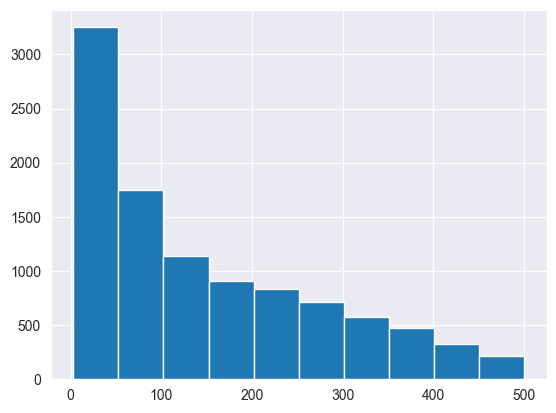

In [17]:
# remove outliers
outlier_idx = data.index[(data.ms > 500) | (data.ms < 3)]
print("outliers", len(outlier_idx))
data = data.drop(outlier_idx)

# remove estimated
data = data.drop(['estimated'], axis=1)

data['function_or_loop_call']=data['Loop'] +data['Statement'] +data['FunctionInvocation']

data = data.drop(['Loop','Statement','FunctionInvocation'], axis=1)

plt.hist(data.ms)

In [18]:
model_features = [
    "function_or_loop_call",
    "GetValue",
    "SetValue",
    "CreateAccount",
    "EVMGasUsage",
];

In [19]:
corr = data[
    model_features
].corr('pearson')
corr

,function_or_loop_call,GetValue,SetValue,CreateAccount,EVMGasUsage
function_or_loop_call,1.000000,-0.078139,0.091059,-0.143126,-0.078526
GetValue,-0.078139,1.000000,-0.033744,-0.019237,0.024518
SetValue,0.091059,-0.033744,1.000000,-0.041418,0.322513
CreateAccount,-0.143126,-0.019237,-0.041418,1.000000,-0.050912
EVMGasUsage,-0.078526,0.024518,0.322513,-0.050912,1.000000


<Axes: >

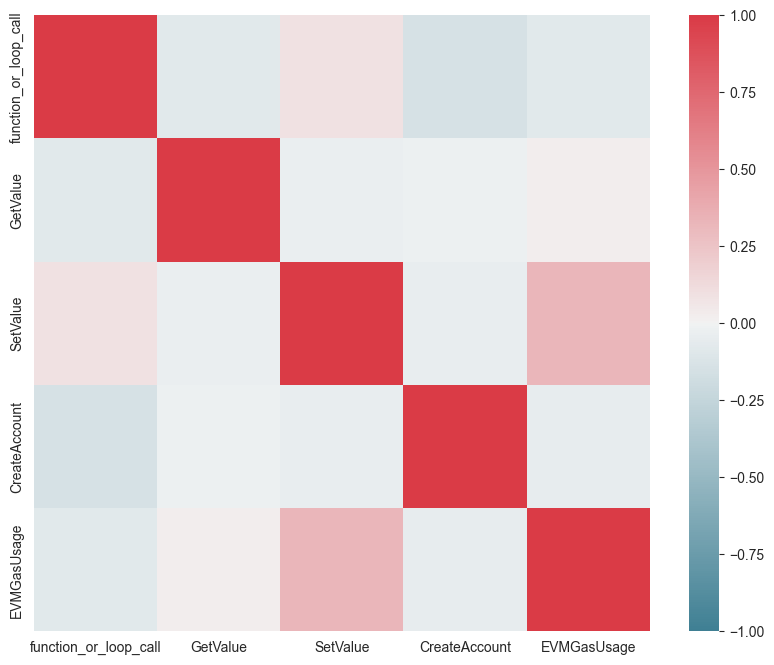

In [20]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            vmin=-1.0, vmax=1.0,
            square=True, ax=ax)


# Linear model 


In [21]:
selected_features = model_features
X_train, X_test, y_train, y_test = model_selection.train_test_split(data[selected_features], data.ms,
                                                                   test_size=0.2)

clf = linear_model.LinearRegression()
clf.fit(X_train[selected_features], y_train)

LinearRegression()

Text(0.5, 1.0, 'Model 1 R2:0.743742652078847')

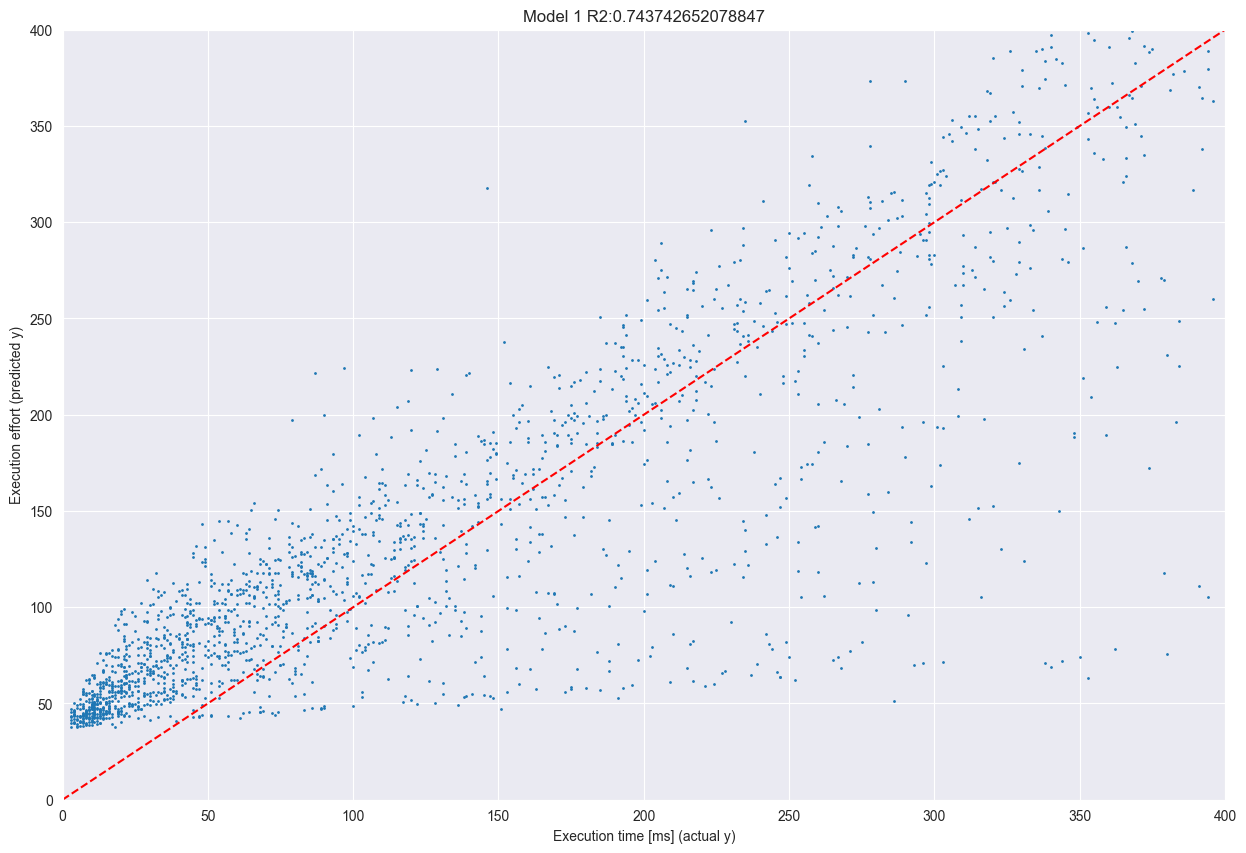

In [22]:
# plt.scatter(y_test,clf.predict(X_test))


diag = np.arange(0., 700., 10.)

fig, ax = plt.subplots(figsize=(15, 10))
ax.set(xlim=(0, 400), ylim=(0, 400))
ax.set_xlabel('Execution time [ms] (actual y)')
ax.set_ylabel('Execution effort (predicted y)')
plt.scatter(y_test, clf.predict(X_test[selected_features]), s=1)
plt.plot(diag, diag, 'r--')
plt.title("Model 1 R2:" + str(clf.score(X_test[selected_features], y_test)))

In [119]:
coefficients = {a: b for a, b in zip(clf.feature_names_in_, clf.coef_) if b != 0}
coefficients

{'function_or_loop_call': 0.0005434377908182418,
 'GetValue': 4.233703657815569e-05,
 'SetValue': 6.931759014514122e-05,
 'CreateAccount': 0.3520825599244242,
 'EVMGasUsage': 3.834779412508516e-06}

# Linear model v1


non_evm_index_len 9592


Text(0.5, 1.0, 'Model 1 R2:0.7526051029825076')

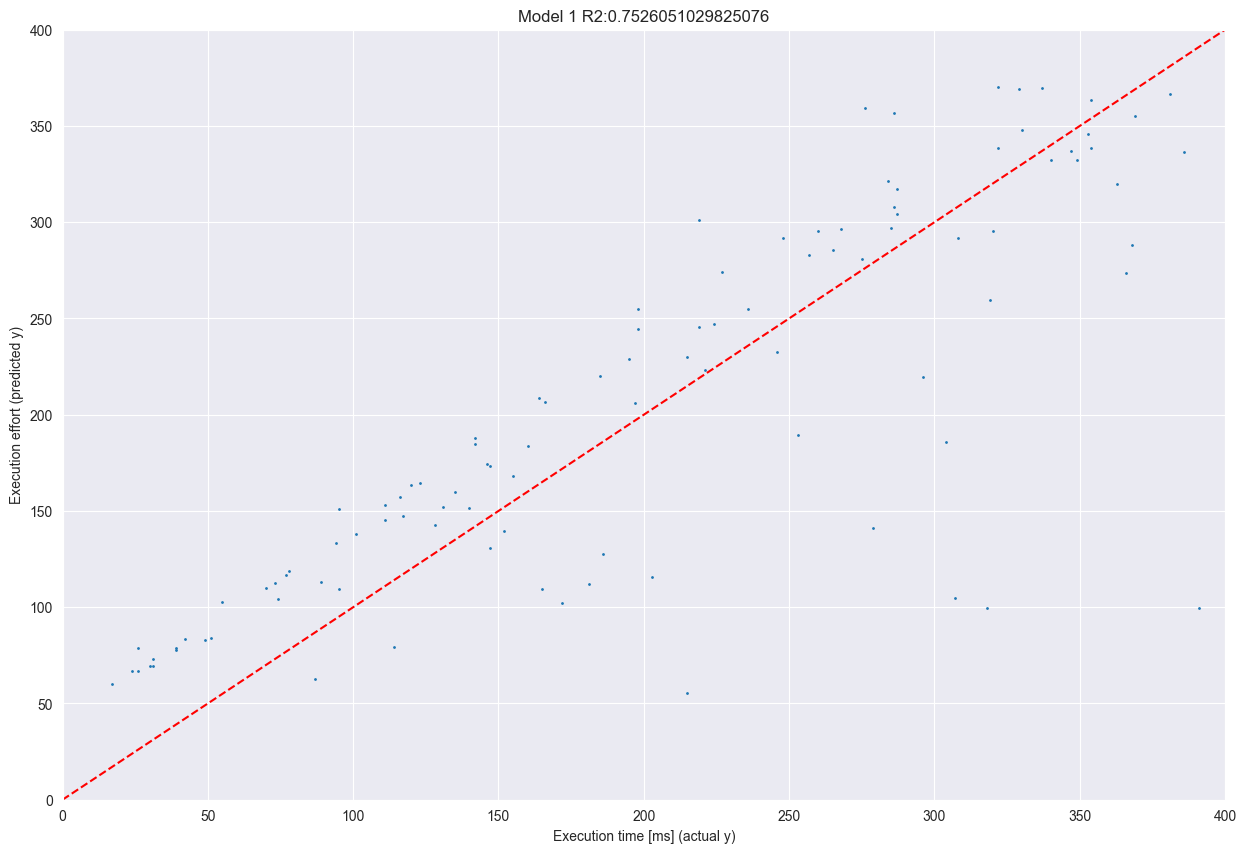

In [23]:
data2=data


data2['existing_model']=data2['function_or_loop_call']* 0.0004789016465827949 +data2['GetValue'] *0.0002466779730553598 +data2['CreateAccount']*0.8660748805785956 + data2['SetValue']*0.0002335080887671281
data2 = data2.drop(['function_or_loop_call','GetValue','CreateAccount','SetValue'], axis=1)

non_evm_index = data2.index[(data.EVMGasUsage == 0)]
print("non_evm_index_len", len(non_evm_index))
data2 = data.drop(non_evm_index)

selected_features = [
    "existing_model",
    "EVMGasUsage",
]
X_train, X_test, y_train, y_test = model_selection.train_test_split(data2[selected_features], data2.ms,
                                                                    test_size=0.2)

clf = linear_model.LinearRegression()
clf.fit(X_train[selected_features], y_train)

diag = np.arange(0., 700., 10.)

fig, ax = plt.subplots(figsize=(15, 10))
ax.set(xlim=(0, 400), ylim=(0, 400))
ax.set_xlabel('Execution time [ms] (actual y)')
ax.set_ylabel('Execution effort (predicted y)')
plt.scatter(y_test, clf.predict(X_test[selected_features]), s=1)
plt.plot(diag, diag, 'r--')
plt.title("Model 1 R2:" + str(clf.score(X_test[selected_features], y_test)))

In [24]:
coefficients = {a: b for a, b in zip(clf.feature_names_in_, clf.coef_) if b != 0}
coefficients

{'existing_model': 0.21084378725635994, 'EVMGasUsage': 4.269623140098493e-06}

In [25]:
 print(1.0/(4.269623140098493e-06 /0.21084378725635994))

49382.294487821266


# Linear model v2


Text(0.5, 1.0, 'Model 1 R2:0.5240310492417868')

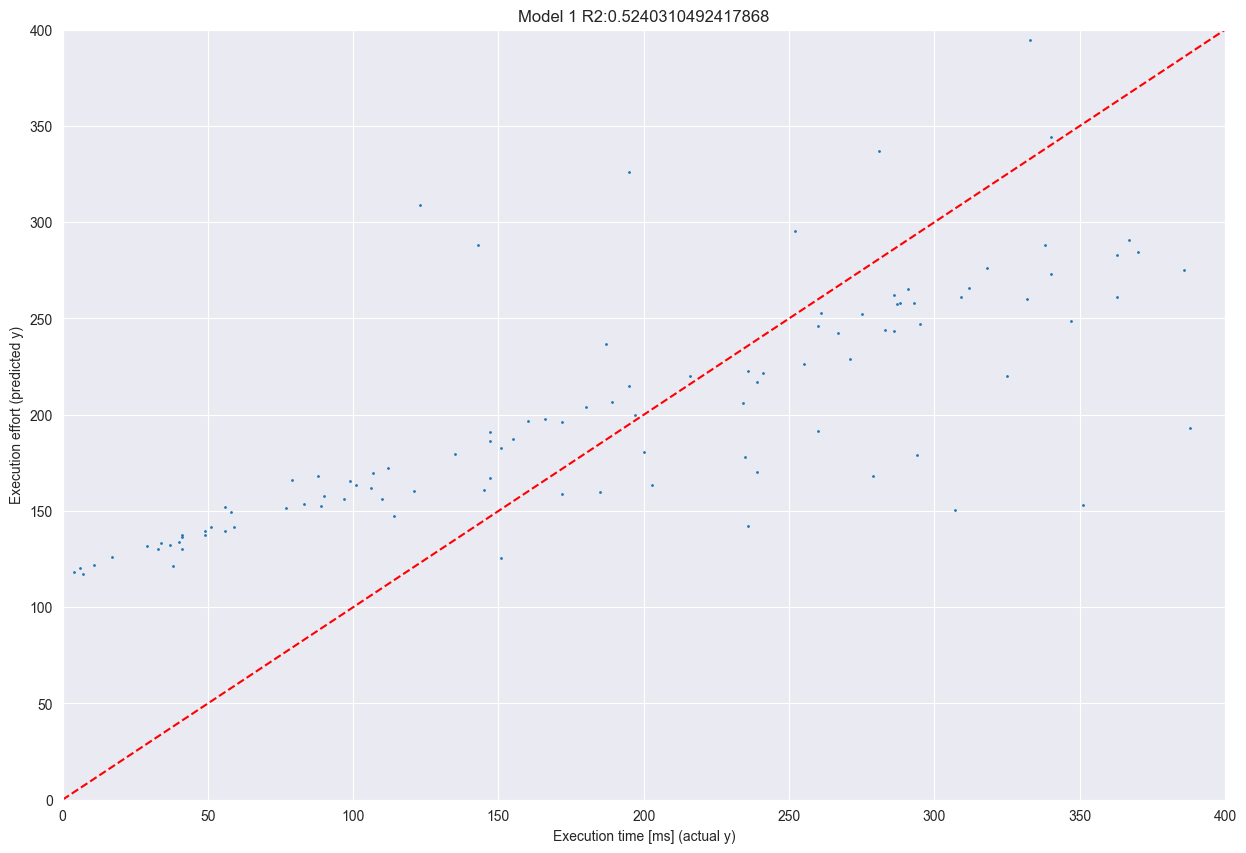

In [26]:


selected_features = [
    "existing_model",
]
X_train, X_test, y_train, y_test = model_selection.train_test_split(data2[selected_features], data2.ms,
                                                                    test_size=0.2)

clf = linear_model.LinearRegression()
clf.fit(X_train[selected_features], y_train)

diag = np.arange(0., 700., 10.)

fig, ax = plt.subplots(figsize=(15, 10))
ax.set(xlim=(0, 400), ylim=(0, 400))
ax.set_xlabel('Execution time [ms] (actual y)')
ax.set_ylabel('Execution effort (predicted y)')
plt.scatter(y_test, clf.predict(X_test[selected_features]), s=1)
plt.plot(diag, diag, 'r--')
plt.title("Model 1 R2:" + str(clf.score(X_test[selected_features], y_test)))

In [27]:
coefficients = {a: b for a, b in zip(clf.feature_names_in_, clf.coef_) if b != 0}
coefficients

{'existing_model': 0.3498890740191668}

In [12]:
 print(1.0/(4.3939989033116545e-06 /0.2263433302713530))

51511.92234043648
